# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


In [1]:
# Basic pandas and numpy
import pandas as pd
import numpy as np
 
# Basic visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
 
# Make jupyter bigger
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

# SKLEARN
from sklearn.model_selection import train_test_split

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [2]:
df = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [6]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

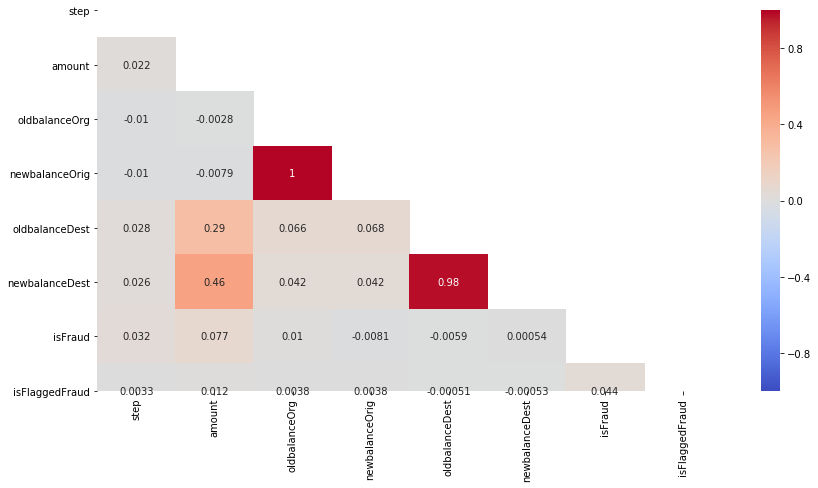

In [7]:
# Set Variables:
cormat = df.corr()
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

There are no variables correlated with our target variable ('isFraud')

### What is the distribution of the outcome? 

In [8]:
target = df.groupby('isFraud')['amount'].count().reset_index()

In [9]:
target

,isFraud,amount
0,0,6354407
1,1,8213


([<matplotlib.axis.XTick at 0x7f01bcca6c88>,
 <a list of 2 Text xticklabel objects>)

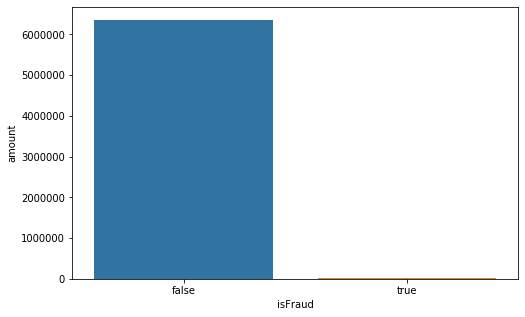

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(target['isFraud'], target['amount'])
plt.xticks(ticks=[0,1], labels=['false', 'true'])

We can see that the outcome variable is very unbalanced.

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

The dataset is clean overall. We can change the step unit (hours) to days by computing them in groups of 24.
In order to do that I create a recursive function that puts the hour of the month inside its adequate day:

In [11]:
def hourtoday(x, limit=24, day=1):
    if x <= limit:
        return day
    else:
        limit += 24
        day += 1
        return hourtoday(x, limit=limit, day=day)

In [12]:
df['day'] = df.step.apply(lambda x: hourtoday(x))

In [13]:
df.drop(columns=['step'], inplace=True)

In [14]:
df.tail()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
6362615,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,31
6362616,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,31
6362617,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,31
6362618,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,31
6362619,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0,31


### Run a logisitc regression classifier and evaluate its accuracy.

I drop nameOrig and nameDest and encode type

In [15]:
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)

In [16]:
one_hot_type = df[['type']].stack().str.get_dummies().sum(level=0).iloc[:,:-1].add_prefix('type_')

In [17]:
df_clean = df.join(one_hot_type)

In [18]:
X = df_clean[[i for i in list(df_clean.columns) if i != 'isFraud']]
y = df_clean['isFraud']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state=20, 
                                                    shuffle=True)

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
logreg = LogisticRegression(random_state=20, solver='lbfgs')

In [23]:
logreg.fit(X_train, y_train)

MemoryError: 

In [ ]:
y_predicted = logreg.predict(X_test)

### Now pick a model of your choice and evaluate its accuracy.

In [ ]:
# Your code here

### Which model worked better and how do you know?

In [ ]:
# Your response here